## Introduction

An example of node classification on a weighted homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

**1.** Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [1]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances


import os
import networkx as nx
import numpy as np
import pandas as pd


from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

%matplotlib inline

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = "~/data/cora"

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx_wt = nx.read_weighted_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx_wt, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_wt = max(nx.connected_component_subgraphs(g_nx_wt, copy=True), key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx_wt.number_of_nodes(), g_nx_wt.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


### Add weights to the edges 
For weighted random walks the edges in the Cora dataset should be weighted. One possibility is to weight each edge by the similarity of its end nodes. Here we weigh each by the jaccard similarity of the features of the pair of nodes.

In [4]:
df = node_attr.copy()
df.set_index(0, inplace = True)
papers = df.index
## calculating the paiwise jaccard similarity between each pair of nodes.
wts = pd.DataFrame(1- pairwise_distances(df.iloc[:,:-1],metric = 'jaccard') , index = papers, columns = papers)
wts.index = wts.index.map(str)
wts.columns = wts.columns.map(str)

/anaconda3/envs/stgraph/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Append the weight attribute to the edges. Note, here we use the word 'weight' to label the weight value over the edge but it can be any other user specified label. 

In [5]:
for u,v in g_nx_wt.edges():
    val = wts[u][v]
    g_nx_wt[u][v]['weight'] = val

Just a quick look at the weights of the edges.

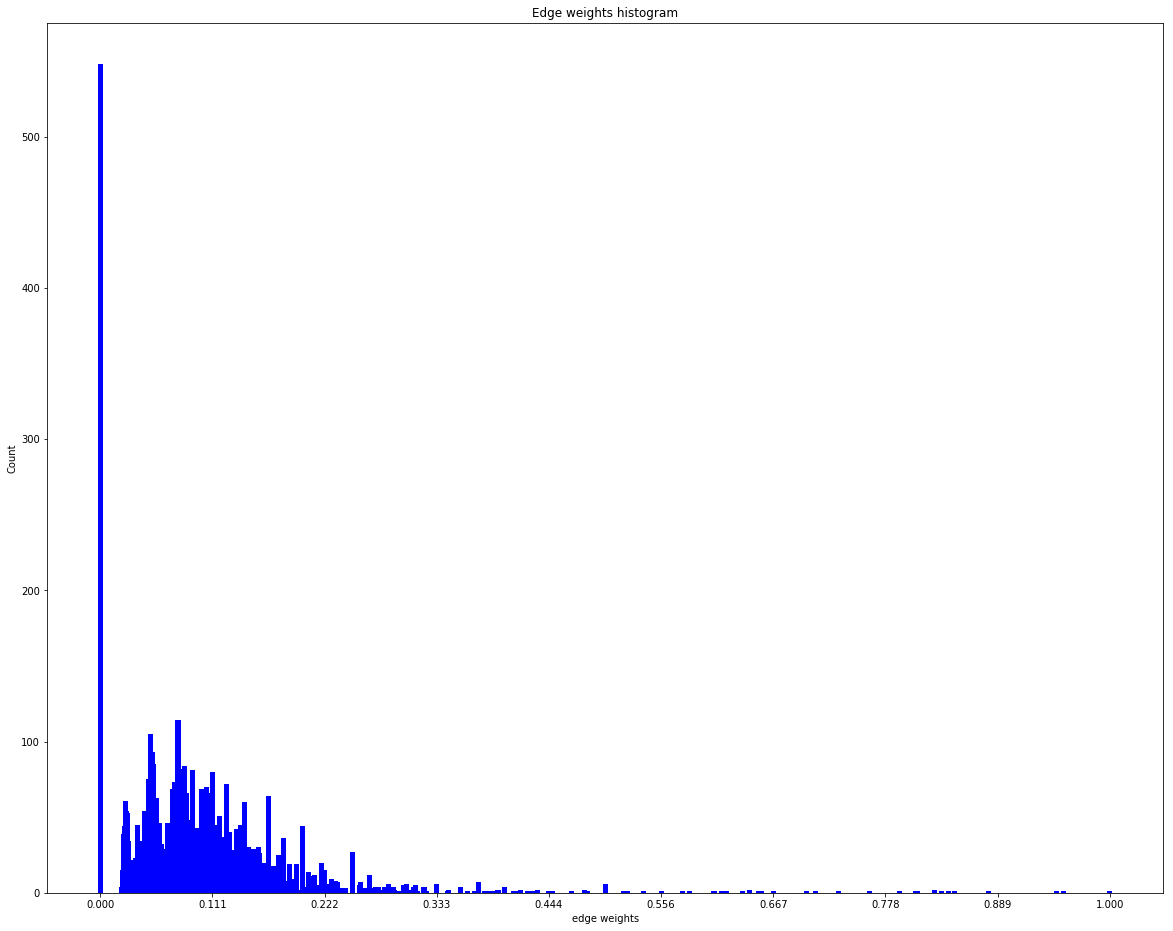

In [6]:
import collections
import matplotlib.pyplot as plt

wts = list()
for u,v in g_nx_wt.edges():
    wts.append(g_nx_wt[u][v]['weight'])
wts = sorted(wts, reverse = True)
edgeCount = collections.Counter(wts)
wt, cnt = zip(*edgeCount.items())

plt.figure(figsize=(20,16))
plt.bar(wt, cnt, width=0.005, color='b')
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0,1,10))

plt.show()

### The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are:

1. Use 2nd order random walks starting from each node to generate a sample of walks on the graph. Note the walks can be longer than 2 but to be consistant with the explanation in [1] we set the random walk to be of length 2. 

2. Based on these random walks generate the embedding form each node. The Word2Vec algorithm, [2], is used for calculating the embedding vectors. In case of graphs, node id is analogous to a unique word/token in a dictionary. A dictionary is a set of words which translates to the complete set of nodes in a graph.


The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective.


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks that can be unweighted or weighted as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q` and `p`, `q`, and `weight` incase the graph is weighted and the a weighted random walk is intended. See [1] for a detailed description of these parameters. 

The first step for the weighted biased random walk is to build a random walk object. This step is exactly as a simple unweighted random walk.

In [7]:
rw = BiasedRandomWalk(StellarGraph(g_nx_wt))

Now, we are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0 and the weight parameter set to True. The `run` method in the random walk will check if the weights are available and resolve any other ambiguity, such as, whether the weights are numeric and their is no ambiguity of edge traversal (multiple edges with different weights between the same pair of nodes).

In [8]:
weighted_walks = rw.run(nodes=list(g_nx_wt.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=10,        # number of random walks per root node 
               p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=2.0,        # Defines (unormalised) probability, 1/q, for moving away from source node
               weighted = True
            )
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


### Representation Learning using Word2Vec

We use the `Word2Vec`, [2], implementation in the free Python library `Gensim`, [3], to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [9]:
from gensim.models import Word2Vec

weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [10]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
weighted_model.wv['19231'].shape

(128,)

### Visualise Node Embeddings generated by weighted  random walks

We retrieve the `Word2Vec` node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

First, the weighted random walks.

In [11]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]

In [12]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

### Plot the embeddings generated from weighted random walks.

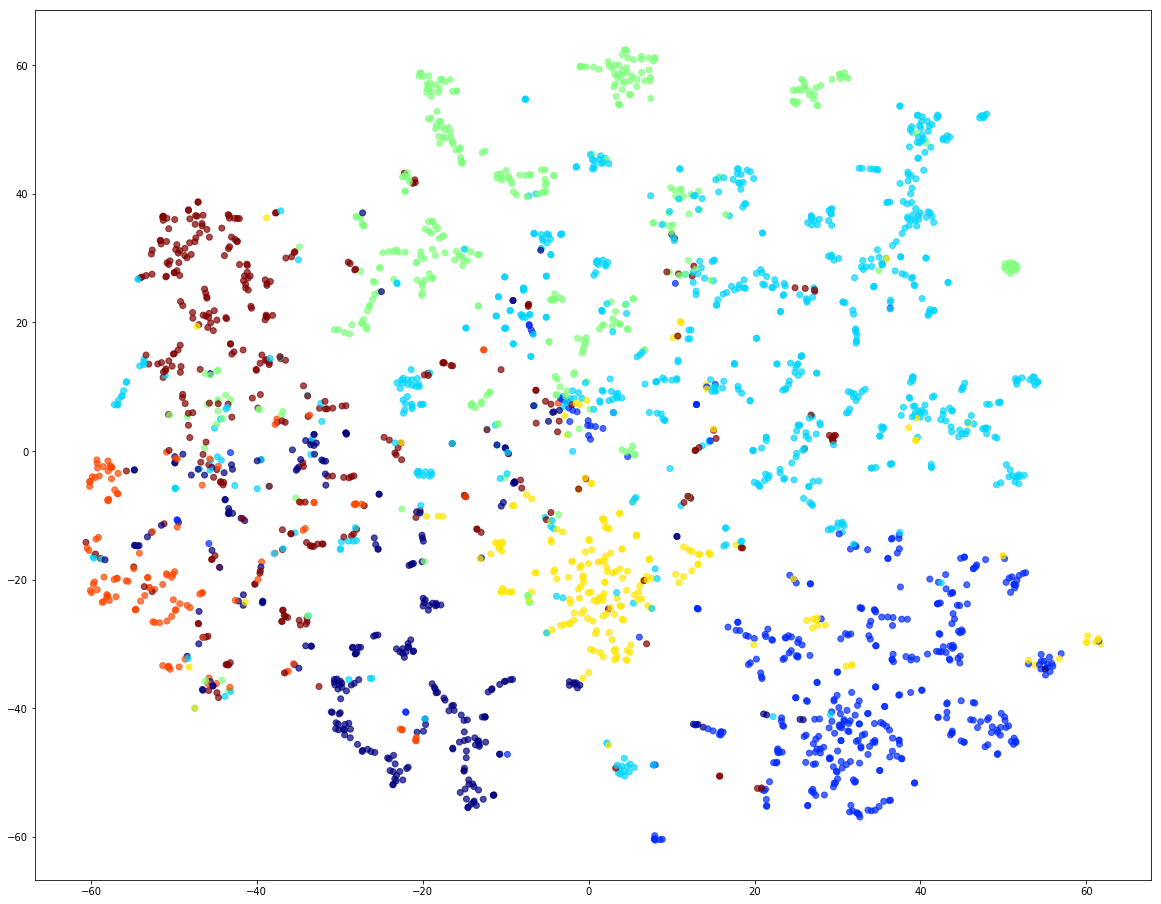

In [13]:
# draw the points
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.scatter(weighted_node_embeddings_2d[:,0], 
            weighted_node_embeddings_2d[:,1], 
            c=node_colours, cmap = "jet", alpha = 0.7)

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will compare the `Node2Vec` node embeddings generated through weighted and unweighted random walks  to train  classifiers to predict the subject of a paper in Cora.

In [14]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)

### Data Splitting

We split the data into train and test sets. 

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=None)

In [16]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [17]:
clf = LogisticRegressionCV( Cs=10, 
                            cv=10, 
                            scoring="accuracy",
                            verbose=False,
                            multi_class='ovr')
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=False)

Predict the hold out test set.

In [18]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [19]:
accuracy_score(y_test, y_pred)

0.7958199356913184

### Comparison to unnweighted random walks

Perform the unweighted random walks. Note, this just requires toggling the weight parameter to False. Also, the weight parameter is by default set to False.

In [20]:
walks = rw.run(nodes=list(g_nx_wt.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=10,        # number of random walks per root node 
               p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=2.0,        # Defines (unormalised) probability, 1/q, for moving away from source node
               weighted = False
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


We use the Word2Vec, [2], to learn representations for each node in the graph.

In [21]:
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [22]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]

In [23]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

### Plot the embeddings generated from unweighted random walks.

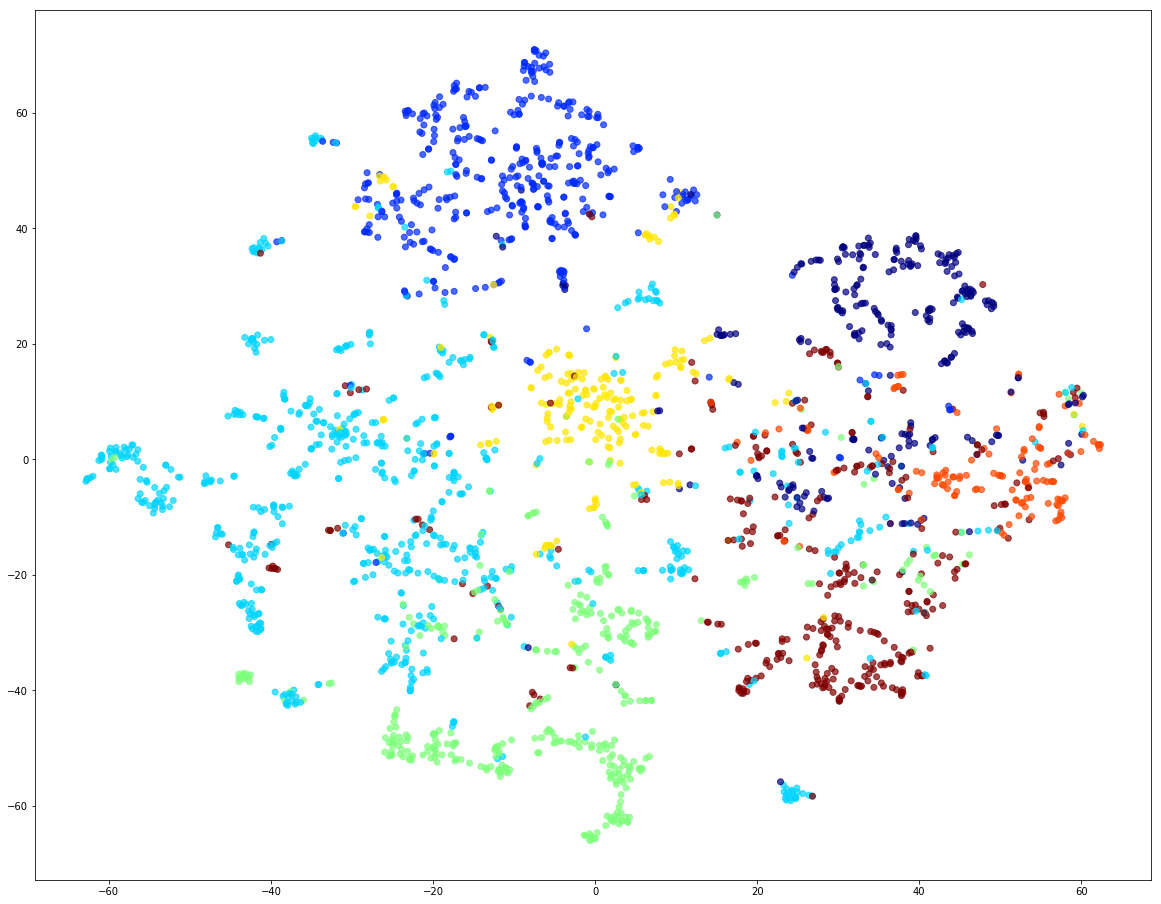

In [24]:
# draw the points
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap = "jet", alpha = 0.7)

### Using unweighted random walks to train classifiers to predict the subject of a paper in Cora.

In [25]:
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=None)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [26]:
clf = LogisticRegressionCV( Cs=10, 
                            cv=10, 
                            scoring="accuracy",
                            verbose=False,
                            multi_class='ovr')
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=False)

In [27]:
y_pred = clf.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred)

0.8295819935691319

### Testing whether weights = 1 gives identical result to unweighted randomwalks

In [29]:
for u,v in g_nx_wt.edges():
    g_nx_wt[u][v]['weight'] = 1

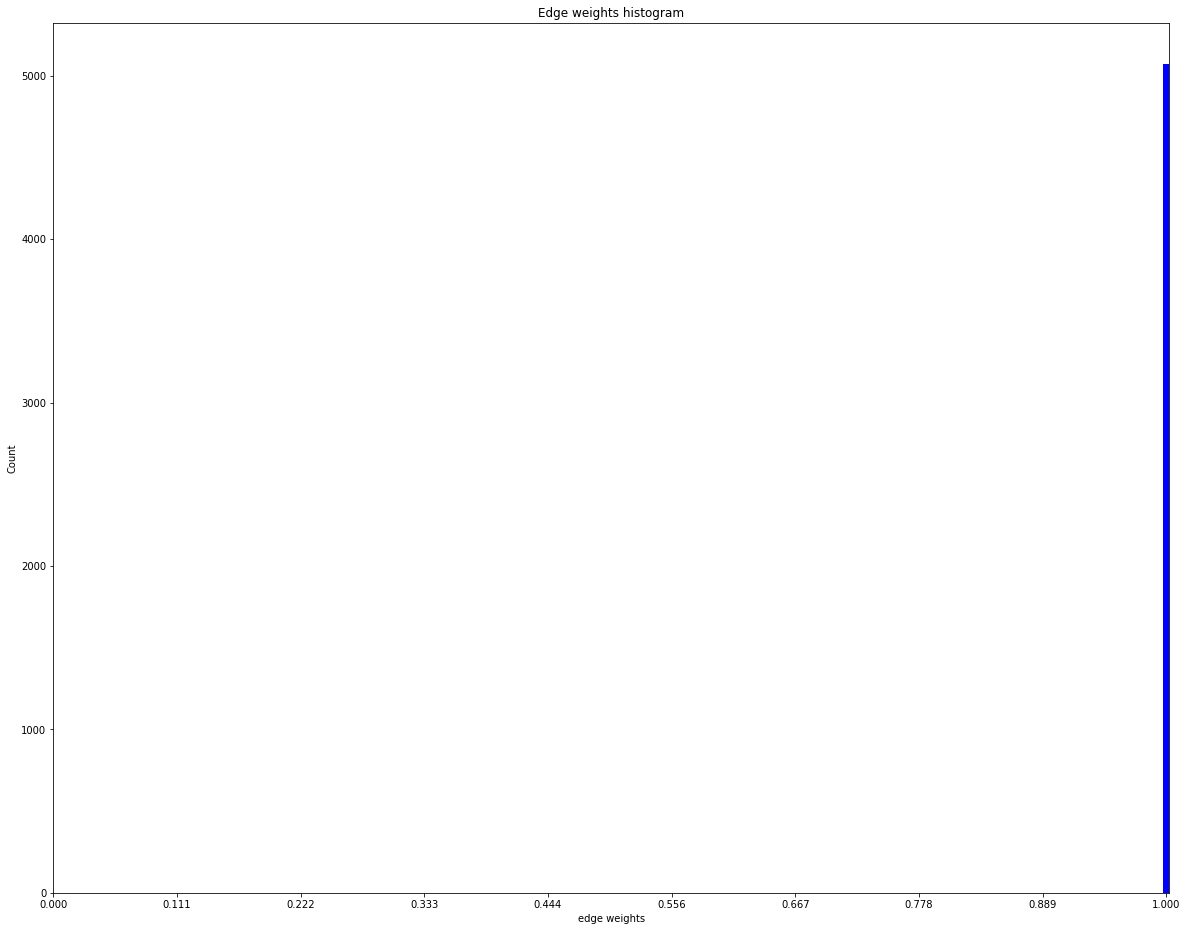

In [31]:
wts = list()
for u,v in g_nx_wt.edges():
    wts.append(g_nx_wt[u][v]['weight'])
wts = sorted(wts, reverse = True)
edgeCount = collections.Counter(wts)
wt, cnt = zip(*edgeCount.items())

plt.figure(figsize=(20,16))
plt.bar(wt, cnt, width=0.005, color='b')
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0,1,10))

plt.show()

In [30]:
weighted_walks = rw.run(nodes=list(g_nx_wt.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=10,        # number of random walks per root node 
               p=0.5,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=2.0,        # Defines (unormalised) probability, 1/q, for moving away from source node
               weighted = True #Flag that indicates whether the walks are weighted
              )
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [32]:
weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [33]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = weighted_model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx_wt.node[node_id]['subject'] for node_id in node_ids]

In [34]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

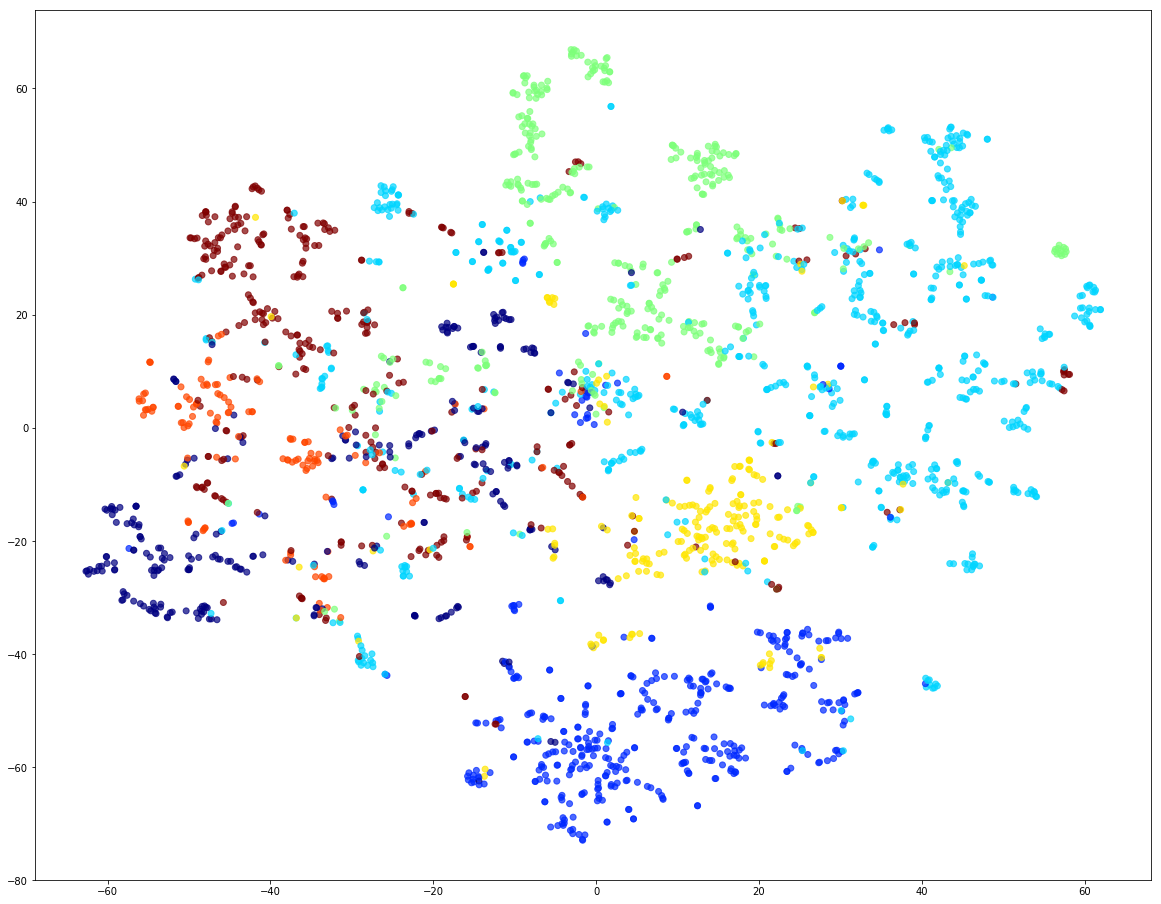

In [35]:
# draw the points
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.scatter(weighted_node_embeddings_2d[:,0], 
            weighted_node_embeddings_2d[:,1], 
            c=node_colours, cmap = "jet", alpha = 0.7)

In [36]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings 
# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=None)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [37]:
clf = LogisticRegressionCV( Cs=10, 
                            cv=10, 
                            scoring="accuracy",
                            verbose=False,
                            multi_class='ovr')
clf.fit(X_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=False)

In [38]:
y_pred = clf.predict(X_test)

In [39]:
accuracy_score(y_test, y_pred)

0.8102893890675241